# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [3]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


In [4]:
print(env.action_space.sample())

print(env.action_space)
print(env.observation_space)

0
Discrete(2)
Box(4,)


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [9]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [10]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [14]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [19]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            #env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 19.0 Training loss: 1.0504 Explore P: 0.9981
Episode: 2 Total reward: 36.0 Training loss: 1.0249 Explore P: 0.9946
Episode: 3 Total reward: 26.0 Training loss: 1.0842 Explore P: 0.9920
Episode: 4 Total reward: 12.0 Training loss: 1.0721 Explore P: 0.9908
Episode: 5 Total reward: 25.0 Training loss: 1.0434 Explore P: 0.9884
Episode: 6 Total reward: 40.0 Training loss: 1.1175 Explore P: 0.9845
Episode: 7 Total reward: 30.0 Training loss: 1.0362 Explore P: 0.9816
Episode: 8 Total reward: 17.0 Training loss: 0.9857 Explore P: 0.9799
Episode: 9 Total reward: 9.0 Training loss: 1.0904 Explore P: 0.9790
Episode: 10 Total reward: 9.0 Training loss: 1.1008 Explore P: 0.9782
Episode: 11 Total reward: 16.0 Training loss: 1.0659 Explore P: 0.9766
Episode: 12 Total reward: 15.0 Training loss: 1.1955 Explore P: 0.9752
Episode: 13 Total reward: 15.0 Training loss: 1.2886 Explore P: 0.9737
Episode: 14 Total reward: 12.0 Training loss: 1.0445 Explore P: 0.9726
Episode: 15 Total

Episode: 117 Total reward: 51.0 Training loss: 4.1230 Explore P: 0.8155
Episode: 118 Total reward: 26.0 Training loss: 26.0201 Explore P: 0.8134
Episode: 119 Total reward: 12.0 Training loss: 32.4580 Explore P: 0.8125
Episode: 120 Total reward: 21.0 Training loss: 111.4863 Explore P: 0.8108
Episode: 121 Total reward: 22.0 Training loss: 4.4543 Explore P: 0.8090
Episode: 122 Total reward: 22.0 Training loss: 48.7466 Explore P: 0.8073
Episode: 123 Total reward: 10.0 Training loss: 32.2641 Explore P: 0.8065
Episode: 124 Total reward: 27.0 Training loss: 92.0642 Explore P: 0.8043
Episode: 125 Total reward: 16.0 Training loss: 2.6386 Explore P: 0.8031
Episode: 126 Total reward: 53.0 Training loss: 2.2683 Explore P: 0.7989
Episode: 127 Total reward: 29.0 Training loss: 71.6351 Explore P: 0.7966
Episode: 128 Total reward: 38.0 Training loss: 2.7317 Explore P: 0.7936
Episode: 129 Total reward: 11.0 Training loss: 30.2458 Explore P: 0.7927
Episode: 130 Total reward: 10.0 Training loss: 30.4110 

Episode: 233 Total reward: 15.0 Training loss: 60.9351 Explore P: 0.6611
Episode: 234 Total reward: 10.0 Training loss: 44.7685 Explore P: 0.6605
Episode: 235 Total reward: 27.0 Training loss: 28.9664 Explore P: 0.6587
Episode: 236 Total reward: 10.0 Training loss: 31.0508 Explore P: 0.6581
Episode: 237 Total reward: 22.0 Training loss: 38.2162 Explore P: 0.6566
Episode: 238 Total reward: 14.0 Training loss: 30.0443 Explore P: 0.6557
Episode: 239 Total reward: 25.0 Training loss: 103.4090 Explore P: 0.6541
Episode: 240 Total reward: 19.0 Training loss: 66.9592 Explore P: 0.6529
Episode: 241 Total reward: 12.0 Training loss: 46.4195 Explore P: 0.6521
Episode: 242 Total reward: 11.0 Training loss: 51.2433 Explore P: 0.6514
Episode: 243 Total reward: 10.0 Training loss: 1.2238 Explore P: 0.6508
Episode: 244 Total reward: 12.0 Training loss: 18.9640 Explore P: 0.6500
Episode: 245 Total reward: 13.0 Training loss: 45.8466 Explore P: 0.6492
Episode: 246 Total reward: 18.0 Training loss: 36.3

Episode: 346 Total reward: 78.0 Training loss: 18.0104 Explore P: 0.4457
Episode: 347 Total reward: 60.0 Training loss: 1.2803 Explore P: 0.4431
Episode: 348 Total reward: 119.0 Training loss: 42.2246 Explore P: 0.4380
Episode: 349 Total reward: 62.0 Training loss: 1.9554 Explore P: 0.4353
Episode: 350 Total reward: 36.0 Training loss: 2.4945 Explore P: 0.4338
Episode: 351 Total reward: 52.0 Training loss: 1.3018 Explore P: 0.4316
Episode: 352 Total reward: 14.0 Training loss: 21.6984 Explore P: 0.4310
Episode: 353 Total reward: 99.0 Training loss: 49.9105 Explore P: 0.4269
Episode: 354 Total reward: 47.0 Training loss: 25.0902 Explore P: 0.4249
Episode: 355 Total reward: 44.0 Training loss: 1.7565 Explore P: 0.4231
Episode: 356 Total reward: 34.0 Training loss: 40.9785 Explore P: 0.4217
Episode: 357 Total reward: 15.0 Training loss: 38.1933 Explore P: 0.4211
Episode: 358 Total reward: 65.0 Training loss: 2.0848 Explore P: 0.4184
Episode: 359 Total reward: 86.0 Training loss: 61.9739 E

Episode: 467 Total reward: 35.0 Training loss: 1.4743 Explore P: 0.1466
Episode: 469 Total reward: 112.0 Training loss: 0.4985 Explore P: 0.1424
Episode: 471 Total reward: 164.0 Training loss: 0.3077 Explore P: 0.1376
Episode: 472 Total reward: 190.0 Training loss: 0.7076 Explore P: 0.1352
Episode: 475 Total reward: 99.0 Training loss: 0.9503 Explore P: 0.1291
Episode: 477 Total reward: 46.0 Training loss: 250.0772 Explore P: 0.1262
Episode: 479 Total reward: 139.0 Training loss: 0.7657 Explore P: 0.1224
Episode: 482 Total reward: 18.0 Training loss: 0.7008 Explore P: 0.1178
Episode: 483 Total reward: 177.0 Training loss: 0.4726 Explore P: 0.1159
Episode: 485 Total reward: 42.0 Training loss: 0.6090 Explore P: 0.1133
Episode: 487 Total reward: 174.0 Training loss: 0.5149 Explore P: 0.1095
Episode: 490 Total reward: 99.0 Training loss: 0.6928 Explore P: 0.1047
Episode: 493 Total reward: 99.0 Training loss: 0.5571 Explore P: 0.1001
Episode: 496 Total reward: 99.0 Training loss: 0.5003 Ex

Episode: 610 Total reward: 18.0 Training loss: 2.8104 Explore P: 0.0522
Episode: 611 Total reward: 20.0 Training loss: 2.8656 Explore P: 0.0521
Episode: 612 Total reward: 15.0 Training loss: 4.5197 Explore P: 0.0520
Episode: 613 Total reward: 20.0 Training loss: 2.7909 Explore P: 0.0519
Episode: 614 Total reward: 25.0 Training loss: 39.1670 Explore P: 0.0518
Episode: 615 Total reward: 19.0 Training loss: 364.2004 Explore P: 0.0517
Episode: 616 Total reward: 19.0 Training loss: 2.7785 Explore P: 0.0517
Episode: 617 Total reward: 17.0 Training loss: 2.4328 Explore P: 0.0516
Episode: 618 Total reward: 14.0 Training loss: 5.6853 Explore P: 0.0515
Episode: 619 Total reward: 15.0 Training loss: 372.2824 Explore P: 0.0515
Episode: 620 Total reward: 18.0 Training loss: 52.8102 Explore P: 0.0514
Episode: 621 Total reward: 20.0 Training loss: 5.9020 Explore P: 0.0513
Episode: 622 Total reward: 25.0 Training loss: 4.4345 Explore P: 0.0512
Episode: 623 Total reward: 28.0 Training loss: 374.0233 Ex

Episode: 786 Total reward: 99.0 Training loss: 16.3919 Explore P: 0.0147
Episode: 789 Total reward: 99.0 Training loss: 0.1116 Explore P: 0.0145
Episode: 792 Total reward: 90.0 Training loss: 0.0884 Explore P: 0.0143
Episode: 795 Total reward: 90.0 Training loss: 0.1456 Explore P: 0.0141
Episode: 798 Total reward: 52.0 Training loss: 0.2398 Explore P: 0.0139
Episode: 801 Total reward: 99.0 Training loss: 0.1272 Explore P: 0.0137
Episode: 804 Total reward: 99.0 Training loss: 0.1500 Explore P: 0.0135
Episode: 806 Total reward: 181.0 Training loss: 669.9269 Explore P: 0.0134
Episode: 809 Total reward: 64.0 Training loss: 0.1779 Explore P: 0.0132
Episode: 812 Total reward: 70.0 Training loss: 0.2461 Explore P: 0.0131
Episode: 814 Total reward: 185.0 Training loss: 0.2794 Explore P: 0.0130
Episode: 817 Total reward: 11.0 Training loss: 0.2307 Explore P: 0.0128
Episode: 819 Total reward: 146.0 Training loss: 0.3778 Explore P: 0.0127
Episode: 821 Total reward: 146.0 Training loss: 0.1845 Exp

Episode: 942 Total reward: 13.0 Training loss: 2.1162 Explore P: 0.0114
Episode: 943 Total reward: 11.0 Training loss: 2.7819 Explore P: 0.0114
Episode: 944 Total reward: 15.0 Training loss: 1.7257 Explore P: 0.0114
Episode: 945 Total reward: 11.0 Training loss: 4.8988 Explore P: 0.0114
Episode: 946 Total reward: 13.0 Training loss: 665.4777 Explore P: 0.0114
Episode: 947 Total reward: 13.0 Training loss: 0.7932 Explore P: 0.0114
Episode: 948 Total reward: 21.0 Training loss: 5.4757 Explore P: 0.0114
Episode: 949 Total reward: 28.0 Training loss: 1.3951 Explore P: 0.0114
Episode: 950 Total reward: 132.0 Training loss: 2.0101 Explore P: 0.0114
Episode: 952 Total reward: 2.0 Training loss: 2.4270 Explore P: 0.0114
Episode: 953 Total reward: 125.0 Training loss: 1.5622 Explore P: 0.0113
Episode: 954 Total reward: 16.0 Training loss: 1.5758 Explore P: 0.0113
Episode: 955 Total reward: 19.0 Training loss: 2.0121 Explore P: 0.0113
Episode: 956 Total reward: 17.0 Training loss: 240.9882 Explo

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

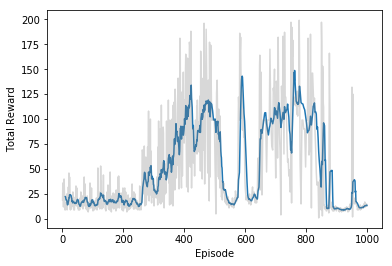

In [21]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.